*Luis Antonio Ortega Andrés    
Antonio Coín Castro* $\DeclareMathOperator*{\argmin}{arg\,min}$

# Gradient Boosting

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.base import BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.dummy import DummyRegressor

%matplotlib inline

### Funciones auxiliares

In [23]:
def plotModel(x,y,clase,clf,title="", stage = None):
    from matplotlib.colors import ListedColormap
    
    x_min, x_max = x.min() - .2, x.max() + .2
    y_min, y_max = y.min() - .2, y.max() + .2
    hx = (x_max - x_min)/100.
    hy = (y_max - y_min)/100.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    separator= 0.0
    if stage is None:
        if hasattr(clf, "decision_function"):
            z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        elif hasattr(clf, "predict_proba"):
            z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            separator = 0.5
        else:
            z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    else:
        z = clf.predict_staged(np.c_[xx.ravel(), yy.ravel()], stage)[stage]

    z = z.reshape(xx.shape)
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    plt.contourf(xx, yy, z, cmap=cm, alpha=.8)
    plt.contour(xx, yy, z, [separator], linewidths=[2], colors=['k'])

    if clase is not None:
        plt.scatter(x[clase==-1], y[clase==-1], c='#FF0000')
        plt.scatter(x[clase==1], y[clase==1], c='#0000FF')
    else:
        plt.plot(x,y,'g', linewidth=3)
        
    plt.gca().set_xlim(xx.min(), xx.max())
    plt.gca().set_ylim(yy.min(), yy.max())
    plt.grid(True)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

In [24]:
def createDataSet(n, model, ymargin, noise=None, output_boundary=False):
    x = np.random.rand(n,1)*2.0*np.pi
    xbnd = np.linspace(0,2.0*np.pi,100)

    if model == 'sine':
        y = (np.random.rand(n,1) - 0.5)*2.2
        c = y > np.sin(x)
        ybnd = np.sin(xbnd)
    elif model == 'linear':
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    elif model == 'square':
        y = np.random.rand(n,1)*4.0*np.pi*np.pi
        c = y > x*x
        ybnd = xbnd*xbnd
    else:
        y = np.random.rand(n,1)*2.0*np.pi
        c = y > x
        ybnd = xbnd
    
    y[c == True] = y[c == True] + ymargin
    y[c == False] = y[c == False] - ymargin
    
    if noise is not None:
        y = y + noise * np.random.randn(n,1)
        x = x + noise * np.random.randn(n,1)

    if output_boundary == True:
        return x, y, (c*1).ravel(), xbnd, ybnd
    else:
        return x, y, (c*1).ravel()

In [25]:
def plotData(x,y,c,style0,style1,title=''):
    plt.scatter(x[c==-1],y[c==-1],**style0)
    plt.scatter(x[c==1],y[c==1],**style1)
    plt.grid(True)
    plt.axis([x.min()-0.2, x.max()+0.2, y.min()-0.2, y.max()+0.2])
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)

## Análisis teórico del algoritmo

El algoritmo de Gradient Boosting persigue construir un estimador *ensemble* mediante un modelo aditivo, es decir, como suma de estimadores débiles (*weak estimators*). La idea general es obtener un estimador $F(x)$ de la forma

$$F(x)=\sum_{i=1}^M \gamma_mh_m(x),$$

de manera que realizamos una construcción iterativa en M pasos:

$$F_m(x)=F_{m-1}(x) + \gamma_mh_m(x), \quad m=1,\dots,M.$$

Los multiplicadores $\gamma_m$ son constantes que marcan el tamaño del paso y ponderan el peso de cada estimador débil. El objetivo es optimizar los valores de $\gamma_m$ y $h_m$ para minimizar la pérdida entre las predicciones y los valores reales en el conjunto de entrenamiento, utilizando un esquema de gradiente descendente. De esta forma, definimos nuestro estimador inicial como aquella constante que minimiza la función de pérdida.

Pasamos ahora a describir el algoritmo de Gradient Boosting:

**Entrada**: 

- Conjunto de entrenamiento $\{(x_n, y_n)\}_{n=1,\dots,N}$.
- Función de pérdida puntual diferenciable $L(y,F(x))$.
- Número de iteraciones $M$.

**Procedimiento**:

1. Se inicializa el modelo con un estimador constante que minimice la pérdida esperada:
$$
F_0 (x) = \argmin_{\gamma \in \mathbb R} \sum_{n=1}^N L(y_n, \gamma).
$$
2. Para $m = 1,\dots,M$:
    1. Se calculan los *pseudo-residuos*:
    $$
        r_{nm} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} \quad n = 1,\dots,N.
    $$
    
    2. Se ajusta un modelo base $h_m(x)$ a los pseudo-residuos, es decir, se entrena $h_m$ sobre el conjunto $\{x_n, r_{nm}\}_{n=1,\dots,N}$.
    3. Se estima el multiplicador $\gamma_m$ que minimiza el error en entrenamiento, utilizando si es necesario un único paso del método de Newton-Raphson:
    $$
    \gamma_m = \argmin_\gamma \sum_{n=1}^N L(y_n, F_{m-1}(x_n) + \gamma h_m(x_n)).
    $$
    4. Se actualiza el modelo:
    $$
    F_m(x) =F_{m-1}(x) + \gamma_m h_m(x).
    $$
    
3. Devolvemos $F_M(x)$ como modelo final en el caso de regresión, o alguna transformación del mismo para clasificación, que transforme valores continuos en etiquetas de clase teniendo en cuenta cuál es la función de pérdida.

Aunque el algoritmo descrito arriba representa el procedimiento estándar de construcción de estimadores, podemos añadir un par de técnicas de regularización para intentar prevenir el *overfitting*:

1. **Learning rate.** Ponderamos la contribución de cada clasificador débil por un valor $0 < \nu \leq 1$, de forma que
$$F_{m}(x)=F_{m-1}(x) + \nu\gamma_mh_m(x)$$

2. **Stochastic Gradient Boosting.** Se trata de una modificación propuesta por J. Friedman ([paper](https://statweb.stanford.edu/~jhf/ftp/stobst.pdf)) en la que en cada etapa se utiliza una fracción de los datos para calcular los residuos, entrenar el clasificador débil y calcular los multiplicadores.

### Error cuadrático

Para el caso de regresión utilizamos como función de pérdida el error cuadrático entre predicciones y valores reales (convenientemente dividido entre 2 para simplificar los cálculos):

$$
L(y, F(x)) = \frac{1}{2}(y - F(x))^2.
$$

Veamos ahora con detalle cuáles son los elementos que modelan el algoritmo en este caso.

1. **Estimador inicial**. El valor que minimiza la pérdida cuadrática coincide con la media de las respuestas de los datos de entrenamiento:
$$
F_0(x) = \argmin_\gamma \sum_{n=1}^N L(y_n, \gamma) = \argmin_\gamma \sum_{n=1}^N (y_n - \gamma)^2
$$
$$
\dfrac{\partial \sum_{n=1}^N L(y_n, \gamma)}{\partial \gamma} = -\sum_{n=1}^N(y_n - \gamma) = 0 \implies F_0(x) = \frac{1}{N}\sum_{n=1}^N y_n = \bar{y}.
$$

2. **Pseudo-residuos**. Como la función de pérdida es derivable, podemos calcular explícitamente su derivada parcial respecto de la segunda variable:
$$
r_{nm} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = -\left[ \frac{\partial}{\partial F(x_n)}\frac{1}{2}(y_n - F(x_n))^2 \right]_{F(x) = F_{m-1}(x)} = y_n - F_{m-1}(x_n).$$

3. **Multiplicador**. Queremos minimizar en $\gamma$ la siguiente función:
$$
f_m(\gamma) = \sum_{n=1}^N \frac{1}{2}(y_n - F_{m-1}(x_n) - \gamma h_m(x_n))^2
$$
Para ello, pretendemos calcular su derivada e igualarla a $0$. En primer lugar, se tiene:
$$
f_m'(\gamma) = \sum_{n=1}^N -h_m(x_n)(y_n - F_{m-1}(x_n) - \gamma h_m(x_n)) 
$$
Ahora, como $h_m$ se ha entrenado para que
$$
h_m(x_n) \approx r_{nm} = y_n- F_{m-1}(x_n),
$$
podemos aproximar:
$$
f_m'(\gamma) = \sum_{n=1}^N - (y_n- F_{m-1}(x_n))(y_n- F_{m-1}(x_n) - \gamma (y_n- F_{m-1}(x_n))) = (\gamma - 1) \sum_{n=1}^N (y_n- F_{m-1}(x_n))^2.
$$
Por tanto, concluimos que:
$$
f_m'(\gamma)= 0 \implies \gamma_m^* = 1.$$

Teniendo todo esto en cuenta, creamos una clase que represente estos elementos para la pérdida cuadrática.

In [115]:
class SquaredErrorLoss:
    """ 
    Define elementos para la función de pérdida cuadrática.
    """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la pérdida con la salida 'y'. 
            Para la pérdida cuadrática este valor coincide con la media de los 
            valores de 'y'. """
        
        return np.mean(y)

    def residuals(_, y, F):
        """ Calcula los pseudo-residuos para un objetivo 'y' y 
            una salida del modelo 'F'. """

        return y - F

    def newton_step(_, y, residuals, leaf_value):
        """ Recibe información sobre los ejemplos de una hoja dada. En concreto,
              - el conjunto de valores a predecir ('y'), 
              - los pseudo-residuos ('residuals') sobre los que se entrena el nuevo 
                regresor,
              - el valor de la hoja ('leaf_value').
            Calcula el multiplicador asociado a la hoja dada en el paso m.
            
            NOTA: aunque en el desarrollo teórico hemos visto que los multiplicadores
            son 1, esta función está planteada para calcular los valores que van a quedar
            finalmente en las hojas de los árboles de decisión. El hecho de que los 
            multiplicadores sean 1 implica que no se modifica el valor de las hojas. """
        
        # Since all the multipliers are 1, we do not change anything
        return leaf_value
    
    def __call__(_, y, F):
        """ Devuelve el valor de la función de pérdida para un 
            objetivo 'y' y una salida del modelo F. """
        
        return np.mean((y - F) ** 2)

### Error logístico

Hacemos el mismo análisis para el caso de clasificación, utilizando como función de pérdida el error logístico:

$$
L(y, F(x)) = \log(1 + e^{-2yF(x)}), \quad y \in \{-1,1\}.
$$

En este caso la estrategia será un poco distinta, pues aprovecharemos que los estimadores débiles que usamos son árboles de decisión de profundidad $J$, es decir, de la forma 

$$h_m(x)=\sum_{j=1}^{J} b_{jm}\mathcal{I}(x \in R_{jm}),$$

donde $\mathcal I(\cdot)$ es la función indicadora y $\{R_{jm}\}_{j=1,\dots,J}$ son las regiones en las que se divide el espacio de entrada, representadas por las hojas terminales del árbol en el paso $m$-ésimo. En este caso, podemos mejorar la calidad del ajuste calculando un multiplicador diferente en cada nodo, es decir, construyendo los estimadores como

$$F_m(x) = F_{m-1}(x) + \sum_{j=1}^{J} \gamma_{jm}\mathcal{I}(x \in R_{jm}).$$

Notamos que, esto es equivalente a "descartar" los valores $\{b_{jm}\}$ del árbol de decisión y considerar que los multiplicadores son $\gamma_{jm}=\rho_m b_{jm}$, donde $\rho_m$ serían los multiplicadores a nivel de árbol que usaríamos siguiendo el algoritmo general. Por último, teniendo en cuenta que las regiones $\{R_{jm}\}$ son disjuntas, concluimos que

$$\gamma_{jm}= \argmin_\gamma \sum_{x_n \in R_{jm}} L(y_n, F_{m-1}(x_n)+\gamma). $$

Veamos entonces cómo serían los pasos del algoritmo:

1. **Estimador inicial**. En este caso, <a href="#Análisis-del-enfoque-en-el-problema-de-clasificación">se puede demostrar</a> que el valor del estimador constante inicial es:
$$
F_0(x)=\argmin_\gamma \sum_{n=1}^N L(y_n, \gamma) = \argmin_\gamma \sum_{n=1}^N \log(1 + e^{-2y_nF(x_n)}) = \frac{1}{2}\log \left(\frac{1+\bar{y}}{1-\bar y}\right).
$$

2. **Pseudo-residuos**. Se tiene que:
$$
r_{nm} = - \left[ \frac{\partial L(y_n, F(x_n))}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = -\left[ \frac{\partial \log(1 + e^{-2y_nF(x_n)})}{\partial F(x_n)} \right]_{F(x) = F_{m-1}(x)} = \frac{2y_n e^{-2y_nF_{m-1}(x_n)}}{1 + e^{-2y_nF_{m-1}(x_n)}} = \frac{2y_n}{1 + e^{2y_nF_{m-1}(x_n)}}, \quad n = 1,\dots, N.
$$

3. **Multiplicador**. Queremos minimizar en $\gamma$ las siguientes funciones:
$$
f_j(\gamma) = \sum_{x_n \in R_{jm}}L(y_n, F_{m-1}(x_n) + \gamma) = \sum_{x_n \in R_{jm}}\log\left(1 + e^{-2y_n(F_{m-1}(x_n) + \gamma)}\right), \quad j = 1,\dots, J.$$
Como este problema de optimización es complicado, aproximamos el valor del mínimo estimando la raíz de su derivada mediante un único paso del método de Newton-Rhapson, con condición inicial $\gamma=0$:
$$
f_{jm}'(\gamma) = \sum_{x_n \in R_{jm}} \frac{-2y_n  e^{-2y_n(F_{m-1}(x_n)+\gamma)}}{1 + e^{-2y_n(F_{m-1}(x_n)+\gamma)}} = \sum_{x_n \in R_{jm}} \frac{-2y_n}{1 + e^{2y_n(F_{m-1}(x_n)+\gamma)}},
$$
$$
f_{jm}''(\gamma) = \sum_{x_n \in R_{jm}} \frac{4y_n^2e^{2y_n(F_{m-1}(x_n)+\gamma)}}{\left(1 + e^{2y_n(F_{m-1}(x_n)+\gamma)}\right)^2}.
$$
Por tanto, se tiene que:
$$
\gamma_{jm}^{*} = -\frac{f_{jm}'(\gamma = 0)}{f_{jm}''(\gamma = 0)} = \dfrac{\displaystyle \sum_{x_n \in R_{jm}}r_{nm}}{\displaystyle \sum_{x_n \in R_{jm}} \dfrac{2y_ne^{2y_nF_{m-1}(x_n)}2y_n}{(1 + e^{2y_nF_{m-1}(x_n)})(1+e^{2y_nF_{m-1}(x_n)})}}.
$$
Ahora, de la fórmula de $r_{nm}$ deducimos que $e^{2y_nF_{m-1}(x_n)}=\frac{-2y_n-r_{nm}}{r_{nm}}$, y teniendo en cuenta que $y_n\in \{-1, 1\}$, llegamos a que
$$
\gamma_{jm}^{*} =\dfrac{\displaystyle \sum_{x_n \in R_{jm}} r_{nm}}{\displaystyle \sum_{x_n \in R_{jm}}|r_{nm}|(2-|r_{nm}|)}.
$$

4. **Transformación de la salida a etiquetas.** Como esta pérdida la usamos para resolver un problema de clasificación, debemos transformar la salida de nuestro regresor $F_M$ en etiquetas de clase. Para ello utilizamos la función *sigmoide*, adaptada convenientemente para el caso en que las etiquetas son $\pm 1$:
$$
\hat \sigma(x)=\frac{1}{1 + e^{-2x}}
$$
De nuevo, <a href="#Análisis-del-enfoque-en-el-problema-de-clasificación">se puede demostrar</a> que la transformación 
$$
F_M(x) \mapsto \hat \sigma(F_M(x))
$$
transforma la salida en una probabilidad entre $0$ y $1$, de forma que nuestro modelo final queda como
$$
P(y=1\mid x)=\hat \sigma(F_M(x)).
$$
De esta forma, para cada nuevo ejemplo $x$ daremos como predicción la clase $\hat y(x)\in\{-1, 1\}$ que sea más probable, es decir, que verifique 
$$P(y=\hat y\mid x)\ge P(y\neq \hat y\mid x).$$ Dada la simetría entre las etiquetas, y en vista de que la función sigmoide es creciente y toma el valor $0.5$ en $x=0$, tenemos finalmente que esto equivale a
$$
\hat y(x)=\operatorname{signo}(F_M(x)).
$$

*Nota: no aplicamos la estrategia de calcular un multiplicador distinto por cada hoja del árbol en el caso de regresión, ya que en ese caso el estimador final resulta ser el mismo.

In [116]:
class LogLoss:
    """ 
    Define elementos para la función de pérdida logarítmica.
    """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la pérdida con la salida 'y'. """
        
        ybar = np.mean(y)
        
        return 0.5 * np.log((1.0 + ybar) / (1.0 - ybar))

    def residuals(_, y, F):
        """ Calcula los pseudo-residuos para un objetivo 'y' y 
            una salida del modelo 'F'. """

        return (2.0 * y) / (1 + np.exp(2.0 * y * F))

    def newton_step(_, y, residuals, leaf_value):
        """ Recibe información sobre los ejemplos de una hoja dada. En concreto,
              - el conjunto de valores a predecir ('y'), 
              - los pseudo-residuos ('residuals') sobre los que se entrena el nuevo 
                regresor,
              - el valor de la hoja ('leaf_value').
            Calcula el multiplicador asociado a la hoja dada en el paso m. """
        
        rabs = np.abs(residuals)
        
        # Compute numerator and denominator
        numerator = np.sum(residuals)
        denominator = np.sum(rabs * (2.0 - rabs))
        
        # Prevent division by zero and overflow
        if np.abs(denominator) < 1e-50:
            return 0.0

        return numerator / denominator
    
    def raw_preds_to_proba(self, y):
        """ Transforma las predicciones 'y' del regresor final F_M en
            probabilidades de clase {-1, 1}, aplicando una sigmoide. """
        
        proba = np.ones((y.shape[0], 2), dtype = np.float64)
        proba[:, 1] = 1.0 / (1.0 + np.exp(-2.0 * y))
        proba[:, 0] -= proba[:, 1]
        
        return proba
        
    def raw_preds_to_labels(self, y):
        """ Transforma las predicciones 'y' del regresor final F_M en
            etiquetas de clase {-1, 1}, tomando el signo. """
        
        labels = np.sign(y)
        labels[labels == 0] = 1  # np.sign(0) = 0
        
        return labels
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un 
            objetivo 'y' y una salida del modelo F. """
        
        return np.log(1 + np.exp(-2.0 * y * F))

## Implementación de Gradient Boosting

Dividimos la implementación en una clase abstracta `BaseGB` que implementa los métodos comunes, y después de ella heredan una clase para regresión y otra para clasificación.

In [118]:
class BaseGB(BaseEstimator):
    """
    Reúne los métodos comunes de un estimador Gradient Boosting.
    """
    
    def __init__(self, n_estimators, learning_rate, loss, 
                 max_depth, subsample, random_state):
        self.n_estimators   = n_estimators
        self.random_state   = random_state
        self.max_depth      = max_depth
        self.learning_rate  = learning_rate
        self.subsample      = subsample
        self.loss           = loss
    
    def fit(self, X, y): 
        """ Entrena el modelo con los datos de entrenamiento (X, y). """
        
        n = X.shape[0]
        
        # Set public members
        self.estimators_ = []
        self.n_estimators_ = self.n_estimators
        self.n_features_ = X.shape[1]
        self.loss_ = self.loss
        
        if self.subsample < 1.0:
            np.random.seed(self.random_state)
        
        # Get initial constant estimator 
        self.F0 = self.loss_.F0(X, y)
        
        # Set subsample mask
        sample_mask = np.arange(n)
        n_inbag = int(self.subsample * n)
        if n_inbag == 0:
            raise ValueError(
                f"Empty training set after selecting a fraction of {self.subsample} out of {n}")
        
        F = np.full(n, self.F0)
        for m in range(self.n_estimators_):
            # Set base tree learner with desired depth
            tree = DecisionTreeRegressor(criterion = "mse",
                                         max_depth = self.max_depth, 
                                         random_state = self.random_state)
            
            # Select training subset for this iteration
            if self.subsample < 1.0:
                sample_mask = np.random.choice(n, size = n_inbag, replace = False)
            
            # Get pseudo-residuals from loss function
            r = self.loss_.residuals(y[sample_mask], F[sample_mask])
            
            # Fit base learner to pseudo-residuals
            tree.fit(X[sample_mask, :], r)
            
            # Compute multipliers and update tree leaves
            X_leaves_id = tree.apply(X)
            self._update_terminal_regions(X_leaves_id[sample_mask], 
                                          y[sample_mask], r, tree)
            
            # Store current base estimator
            self.estimators_.append(tree)
            
            # Update model
            F += self.learning_rate * tree.tree_.value[X_leaves_id, 0, 0]
            
        return self
    
    def _update_terminal_regions(self, X_leaves_id, y, residuals, tree):
        """ Actualiza las hojas del árbol que corresponden a los ejemplos
            seleccionados, utilizando un único paso del método de Newton-Rhapson
            para encontrar los multiplicadores. """
        
        TREE_LEAF = -1
        tree = tree.tree_
        
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = X_leaves_id == leaf
            tree.value[leaf, 0, 0] = self.loss_.newton_step(y[ii],
                                         residuals[ii],
                                         tree.value[leaf, 0, 0])
    
    def raw_predict(self, X):
        """ Predice la salida del clasificador final sobre los datos X. """
        
        F = np.full(X.shape[0], self.F0)
        for m in range(self.n_estimators_):
            F += self.learning_rate * self.estimators_[m].predict(X)
                
        return F
    
    def raw_predict_staged(self, X, stage):
        """ Predice la salida de todos los clasificadores hasta la etapa 'stage' 
            sobre los datos X. """
        
        preds = [np.full(X.shape[0], self.F0)] \
          + [self.learning_rate * self.estimators_[m].predict(X) for m in range(stage)]
        
        return np.cumsum(preds, axis = 0)
    
    def predict(self, X):
        raise NotImplementedError('predict method not implemented')
        
    def predict_staged(self, X, stage):
        raise NotImplementedError('predict_staged method not implemented')

    def score(self, X, y):
        raise NotImplementedError('score method not implemented')

In [119]:
class RegressorGB(BaseGB):
    """
    Representa un regresor Gradient Boosting.
    """
    
    def __init__(self, n_estimators = 100, loss = SquaredErrorLoss(), 
                 learning_rate = 0.1, max_depth = 3, subsample = 1.0, 
                 random_state = 2020):
        super().__init__(n_estimators, learning_rate, loss, 
                         max_depth, subsample, random_state)
    
    def predict(self, X):
        """ Devuelve los valores predichos por el regresor final para 
            los datos X. """
        
        return self.raw_predict(X)
    
    def predict_staged(self, X, stage):
        """ Devuelve los valores predichos por los regresores hasta la etapa 
            'stage', sobre los datos X. """
        
        return self.raw_predict_staged(X, stage)
            
    def score(self, X, y):
        """ Calcula el MSE entre predicciones y datos reales. """
        
        return SquaredErrorLoss()(y, self.predict(X))

In [120]:
class ClassifierGB(BaseGB):
    """
    Representa un clasificador Gradient Boosting.
    """
    
    def __init__(self, n_estimators = 100, loss = LogLoss(), 
                 learning_rate = 0.1, max_depth = 3, subsample = 1.0, 
                 random_state = 2020):
        
        super().__init__(n_estimators, learning_rate, loss, 
                         max_depth, subsample, random_state)
    
    def fit(self, X, y):
        """ Entrena un clasificador sobre los datos (X, y). """
        
        # Check class labels 
        classes = np.unique(y)
        if (classes != [-1, 1]).any():
            raise ValueError('Binary class labels must be [-1, 1]')
        self.classes_ = classes
        
        # Fit model
        super().fit(X, y)
        
        return self
    
    def decision_function(self, X):
        """ Computa la función de decisión del clasificador sobre
            los datos X. """
        
        return self.raw_predict(X)
    
    def predict(self, X):
        """ Devuelve las etiquetas predichas por el clasificador final
            para los datos X. """
        
        raw_predictions = self.raw_predict(X)
        
        return self.loss_.raw_preds_to_labels(raw_predictions)
    
    def predict_staged(self, X, stage):
        """ Devuelve las etiquetas predichas por los clasificadores hasta
            la etapa 'stage' para los datos X. """
        
        raw_predictions_staged = self.raw_predict_staged(X, stage)
        
        return [self.loss_.raw_preds_to_labels(r) for r in raw_predictions_staged]
        
    def predict_proba(self, X):
        """ Devuelve las probabilidades de cada clase predicha por el
            clasificador final, para los datos X. """
        
        raw_predictions = self.raw_predict(X)
        
        return self.loss_.raw_preds_to_proba(raw_predictions)
    
    def score(self, X, y):
        """ Calcula el accuracy de la predicción sobre X frente a
            las etiquetas reales 'y'. """
        
        return np.mean(self.predict(X) == y)

## Casos de prueba

Establecemos un pequeño caso de prueba, que nos servirá tanto para regresión como para clasificación.

In [108]:
np.random.seed(11)
n = 50
model = 'sine'
ymargin = 0
noise = 0.2

# We are using the same points for regresion and classification. 
# For regresion we use (x, y) and for classification ((x,y), c).
Xtrain_reg, Ytrain_reg, Ytrain_class, = createDataSet(n, model, ymargin, noise)
Xtest_reg, Ytest_reg, Ytest_class = createDataSet(5 * n, model, ymargin, noise)

Xtrain_class = np.concatenate((Xtrain_reg, Ytrain_reg), axis = 1)
Xtest_class = np.concatenate((Xtest_reg, Ytest_reg), axis = 1)
Ytrain_reg = Ytrain_reg.ravel()
Ytest_reg = Ytest_reg.ravel()
Ytrain_class[Ytrain_class == 0] = -1
Ytest_class[Ytest_class == 0] = -1

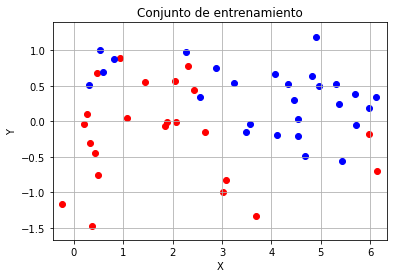

In [109]:
plotData(Xtrain_reg, Ytrain_reg, Ytrain_class, {'c':'#FF0000'},{'c':'#0000FF'})
plt.title("Conjunto de entrenamiento")
_ = plt.plot()

### Regresión

Comparamos las predicciones y el error de nuestro modelo con el de Sklearn, viendo que obtenemos los mismos resultados.

In [121]:
gb = RegressorGB()
gb.fit(Xtrain_reg, Ytrain_reg)

print(f"Training MSE: {gb.score(Xtrain_reg, Ytrain_reg)}")
print(f"Test MSE: {gb.score(Xtest_reg, Ytest_reg)}")

Training MSE: 0.01836335647309569
Test MSE: 0.7153852235771319


In [111]:
gb_sk = GradientBoostingRegressor(criterion="mse", random_state=2020)
gb_sk.fit(Xtrain_reg, Ytrain_reg)

print(f"Training MSE sklearn: {SquaredErrorLoss()(Ytrain_reg, gb_sk.predict(Xtrain_reg))}")
print(f"Test MSE sklearn: {SquaredErrorLoss()(Ytest_reg, gb_sk.predict(Xtest_reg))}")

Training MSE sklearn: 0.01836335647309569
Test MSE sklearn: 0.7153852235771319


### Clasificación

Hacemos lo mismo en el caso del clasificador, viendo que de nuevo obtenemos los mismos resultados que Sklearn. En este caso pintamos además la función de decisión y la proyección del clasificador en el plano.

Training accuracy: 1.0
Test accuracy: 0.896


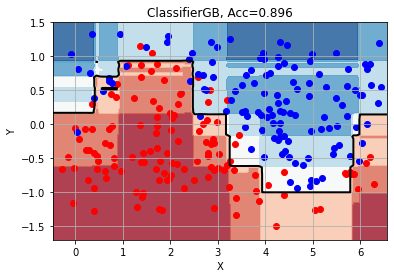

In [122]:
gbc = ClassifierGB()
gbc.fit(Xtrain_class, Ytrain_class)

acc_train = gbc.score(Xtrain_class, Ytrain_class) 
acc_test = gbc.score(Xtest_class, Ytest_class)
print(f"Training accuracy: {acc_train}")
print(f"Test accuracy: {acc_test}")

plotModel(Xtest_reg, Ytest_reg, Ytest_class, gbc, "ClassifierGB, Acc=" + str(acc_test))

Training accuracy: 1.0
Test accuracy: 0.896


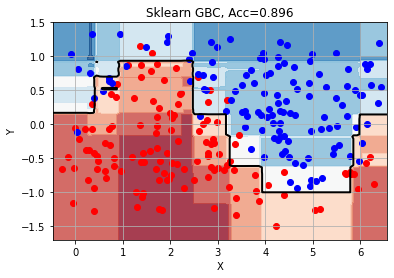

In [36]:
gbc_sk = GradientBoostingClassifier(criterion="mse", random_state=2020)
gbc_sk.fit(Xtrain_class, Ytrain_class)
acc_train = gbc_sk.score(Xtrain_class, Ytrain_class) 
acc_test = gbc_sk.score(Xtest_class, Ytest_class)
print(f"Training accuracy: {acc_train}")
print(f"Test accuracy: {acc_test}")

plotModel(Xtest_reg, Ytest_reg, Ytest_class, gbc_sk, "Sklearn GBC, Acc=" + str(acc_test))

### Curvas de error

Podemos representar gráficamente cómo evoluciona el error del modelo aditivo según el número de iteraciones que hagamos, tanto en regresión como en clasificación.

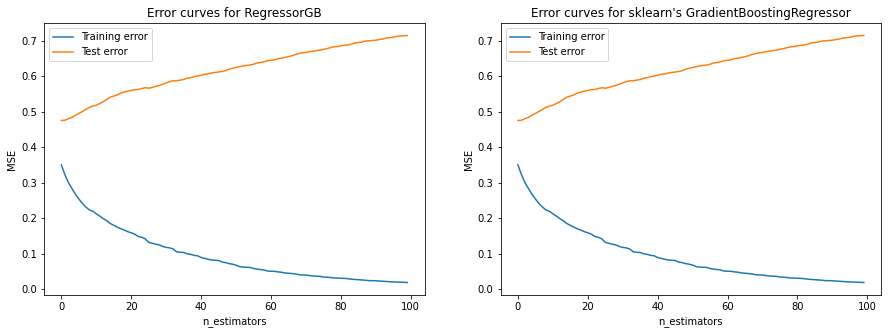

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

Fs_train = gb.predict_staged(Xtrain_reg, gb.n_estimators_)
Fs_error_train = [SquaredErrorLoss()(Ytrain_reg, Fm) for Fm in Fs_train]
Fs_test = gb.predict_staged(Xtest_reg, gb.n_estimators_)
Fs_error_test = [SquaredErrorLoss()(Ytest_reg, Fm) for Fm in Fs_test]
axs[0].plot(np.arange(100), Fs_error_train[1:], label = "Training error")
axs[0].plot(np.arange(100), Fs_error_test[1:], label = "Test error")
axs[0].legend()
axs[0].set_title("Error curves for RegressorGB")
axs[0].set_xlabel("n_estimators")
axs[0].set_ylabel("MSE")

Fs_train = [Fm for Fm in gb_sk.staged_predict(Xtrain_reg)]
Fs_error_train = [SquaredErrorLoss()(Ytrain_reg, Fm) for Fm in Fs_train]
Fs_test = [Fm for Fm in gb_sk.staged_predict(Xtest_reg)]
Fs_error_test = [SquaredErrorLoss()(Ytest_reg, Fm) for Fm in Fs_test]
axs[1].plot(np.arange(100), Fs_error_train, label = "Training error")
axs[1].plot(np.arange(100), Fs_error_test, label = "Test error")
axs[1].legend()
axs[1].set_title("Error curves for sklearn's GradientBoostingRegressor")
axs[1].set_xlabel("n_estimators")
axs[1].set_ylabel("MSE")
plt.show()

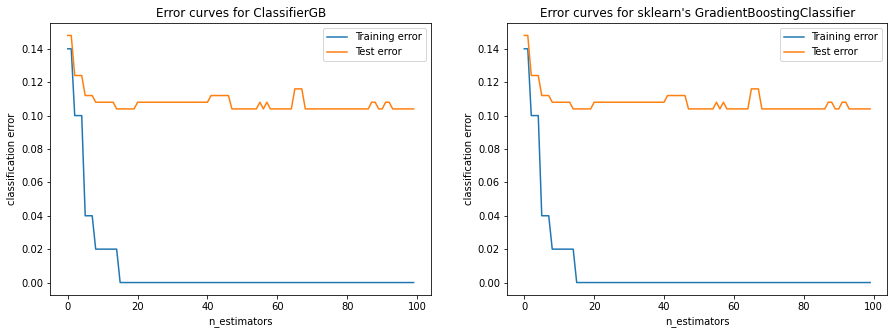

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

Fs_train = gbc.predict_staged(Xtrain_class, gbc.n_estimators_)
Fs_error_train = [np.mean(Ytrain_class != Fm) for Fm in Fs_train]
Fs_test = gbc.predict_staged(Xtest_class, gbc.n_estimators_)
Fs_error_test = [np.mean(Ytest_class != Fm) for Fm in Fs_test]
axs[0].plot(np.arange(100), Fs_error_train[1:], label = "Training error")
axs[0].plot(np.arange(100), Fs_error_test[1:], label = "Test error")
axs[0].legend()
axs[0].set_title("Error curves for ClassifierGB")
axs[0].set_xlabel("n_estimators")
axs[0].set_ylabel("classification error")

Fs_train = [Fm for Fm in gbc_sk.staged_predict(Xtrain_class)]
Fs_error_train = [np.mean(Ytrain_class != Fm) for Fm in Fs_train]
Fs_test = [Fm for Fm in gbc_sk.staged_predict(Xtest_class)]
Fs_error_test = [np.mean(Ytest_class != Fm) for Fm in Fs_test]
axs[1].plot(np.arange(100), Fs_error_train, label = "Training error")
axs[1].plot(np.arange(100), Fs_error_test, label = "Test error")
axs[1].legend()
axs[1].set_title("Error curves for sklearn's GradientBoostingClassifier")
axs[1].set_xlabel("n_estimators")
axs[1].set_ylabel("classification error")
plt.show()

Vemos que de nuevo en ambos casos las curvas de error coinciden (aproximadamente) con las de Sklearn. Por último, podemos ver cómo evoluciona la función de decisión en el caso de clasificación conforme incrementamos el número de estimadores:

<ipython-input-23-1780f3255f4f>:27: UserWarning: No contour levels were found within the data range.
  plt.contour(xx, yy, z, [separator], linewidths=[2], colors=['k'])


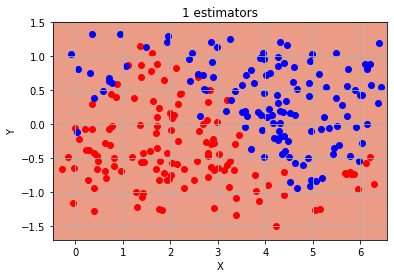

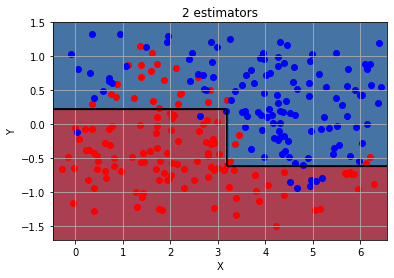

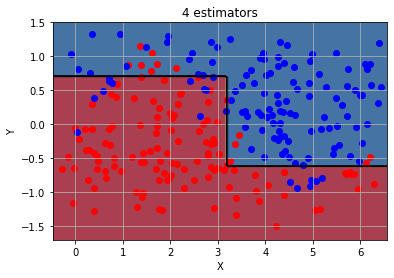

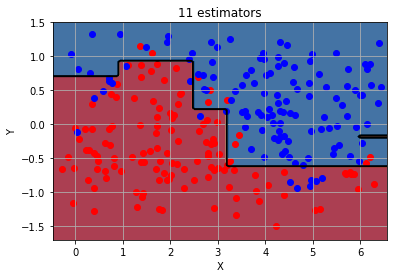

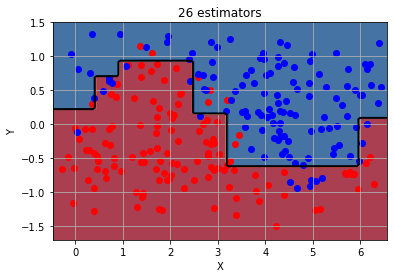

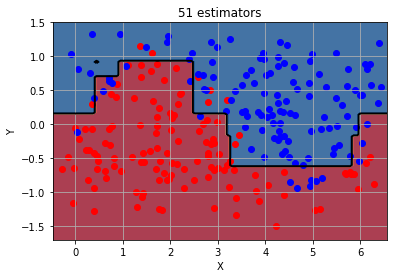

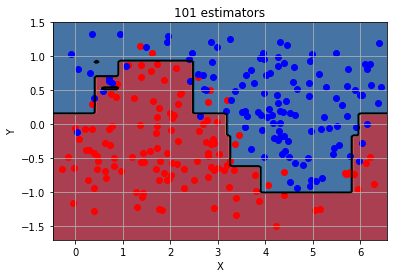

In [123]:
for m in [0, 1, 3, 10, 25, 50, 100]:
    plotModel(Xtest_reg, Ytest_reg, Ytest_class, gbc, title=f"{m+1} estimators", stage = m)
    plt.show()

### Búsqueda de parámetros óptimos

Para concluir, utilizamos un *dataset* "real", `magic04.csv`, para probar nuestro clasificador. Aprovechamos y realizamos *(stratified) $5$-fold cross validation* sobre el conjunto de entrenamiento para encontrar los mejores parámetros.

In [40]:
# Read magic dataset
df = pd.read_csv('magic04.csv', sep = ',')

# Create 80-20 train-test split
X_tr, X_ts, y_tr, y_ts = train_test_split(df.values[:, :-1], df.values[:, -1], 
                                          test_size = 0.8, random_state = 2020)
lb = LabelBinarizer(pos_label = 1, neg_label = -1)
y_tr = lb.fit_transform(y_tr).ravel()
y_ts = lb.transform(y_ts).ravel()

# Fit best model
params = {'n_estimators': [10, 50, 100, 200, 300],
          'max_depth': [1, 2, 3, 4, 5],
          'subsample': [0.5, 0.75, 1.0],
          'learning_rate': [0.01, 0.1, 1.0]}
cv = StratifiedKFold(5, shuffle = True, random_state = 2020)
gs = GridSearchCV(ClassifierGB(), params, scoring='accuracy', cv = cv, verbose = 1, n_jobs = -1)
_ = gs.fit(X_tr, y_tr)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 12.3min finished


In [42]:
print("Best estimator params:", gs.best_params_)
print(f"Training accuracy: {gs.score(X_tr, y_tr):.5f}")
print(f"Test accuracy: {gs.score(X_ts, y_ts):.5f}")

Best estimator params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.75}
Training accuracy: 0.99921
Test accuracy: 0.87145


Vemos que los mejores parámetros encontrados han sido un número elevado de estimadores ($300$), una profundidad máxima de $5$ para cada árbol, un *learning rate* de $0.1$ y utilizar el $75$% (aleatorio) de los datos en cada paso del modelo aditivo. Con estos parámetros obtenemos una precisión prácticamente de $1$ en el conjunto de entrenamiento, y de $0.87$ en el conjunto de *test*.

## Análisis del enfoque en el problema de clasificación

Veamos con un poco más de detalle de dónde se deriva la expresión de la función de pérdida logarítimica, por qué utilizamos el valor inicial $F_0(x)$ que usamos, y por qué podemos aplicar al final del procedimiento una sigmoide para recuperar la probabilidad.

### Derivación de la pérdida logarítmica

En primer lugar, consideremos un modelo de respuesta $Y\in \{-1,1\}$, y llamemos $p(x)=\mathbb P[Y=1\mid x]$. Si consideramos la variable aleatoria $\tilde Y=(Y+1)/2 \in \{0,1\}$, podemos pensar que dada una muestra $x$, sigue una distribución de Bernouilli con probabilidad de éxito $p=p(x)$. Entonces, el *log-likelihood* asociado sería:

$$l(\tilde y, p)=\log\left( p^{\tilde y}(1-p)^{1-\tilde y}\right) = \tilde y \log p + (1-\tilde y)\log(1-p).$$

Ahora, introducimos un clasificador $f=f(x)$, y como queremos que $f(x)=0$ represente equiprobabilidad, parametrizamos $p$ como:

$$\tag{$\ast$}\label{eq:f}p=\frac{e^f}{e^f + e^{-f}}=\frac{1}{1+e^{-2f}}.$$

De esta forma, tenemos que:

$$l(\tilde y, p)=\tilde y \log\left( \frac{1}{1+e^{-2f}}\right) + (1-\tilde y) \log \left( \frac{1}{1+e^{2f}}\right)=-\tilde y(1+e^{-2f}) -(1-\tilde y)(1+e^{2f})$$
$$=\begin{cases} -\log(1+e^{2f}),& \text{si }\tilde y = 0\\
-\log(1+e^{-2f}),& \text{si } \tilde y=1\end{cases} =-\log(1+e^{-2yf}).$$

La última igualdad se deriva del hecho de que $\tilde y = 1\iff y=1$ y $\tilde y = 0 \iff y=-1$. Ahora, sabemos que  una estrategia muy extendida consiste en maximizar el *likelihood*, o lo que es equivalente, minimizar el *log-likelihood* negativo. Por tanto, nuestro objetivo es minimizar la función de pérdida puntual
$$l(y,f)=\log(1+e^{-2yf}),$$

o mejor dicho, su esperanza bajo $(X, Y)$. Para ello utilizamos la técnica *ERM*, *Empirical Risk Minimization*, que consiste en minimizar la media muestral de estas pérdidas puntuales sobre las observaciones de las que disponemos.

### Deducción del estimador inicial

Pretendemos minimizar entonces

$$\mathbb E_{XY}[l(Y,f(X))]=E_X[E_{Y\mid x}[l(Y,f(x))]]$$

[Se comprueba fácilmente](https://stats.stackexchange.com/questions/431673/conditional-expectation-and-prediction) que para minimizar la expresión anterior es suficiente con minimizarla punto a punto (para cada $x$). Atendiendo a las expresiones anteriores, se tiene que, para un dato $x$ fijo:

$$\mathbb E_{Y\mid x}[l(Y, f(x))]=p\log(1+e^{-2f(x)}) + (1-p)\log(1+e^{2f(x)}) = p\log(1+e^{-2f(x)}) - (1-p)\log\left( \frac{e^{-2f(x)}}{1+e^{-2f(x)}}\right)$$
$$=2f(x)(1-p)+\log(1+e^{-2f(x)}).$$

Derivando esta expresión con respecto a $f(x)$ e igualando a $0$, obtenemos:

$$-2\frac{e^{-2f(x)}}{1+e^{-2f(x)}}+2(1-p)=0 \implies \frac{e^{-2f(x)}}{1+e^{-2f(x)}}=1-p$$
$$\implies e^{-2f(x)}p = 1-p \implies f^\ast(x)=\frac{1}{2}\log\left(\frac{p}{1-p}\right).$$

Es decir, el estimador que minimiza el riesgo esperado (*population minimizer*) es $\frac{1}{2}\log\left(\frac{p(x)}{1-p(x)}\right)$. En $F_0$ buscamos un estimador **constante** que minimice el riesgo empírico. Para estimar este valor con los datos de los que disponemos, simplemente sustituimos $p$ por la frecuencia $\hat p$ de etiquetas $y=1$ en el dataset. De esta forma, si $N$ es el tamaño del dataset y $n_i$ indica el número de etiquetas con valor $i$, se tiene que:

$$\frac{\hat p}{1-\hat p}=\frac{2n_1}{2n_{-1}}=\frac{N+n_1-n_{-1}}{N-n_1+n_{-1}}=\frac{1+\frac{1}{N}(n_1-n_{-1})}{1-\frac{1}{N}(n_1-n_{-1})}=\frac{1+\bar y}{1-\bar y}.$$

Por tanto, 

$$F_0 \equiv\frac{1}{2}\log\left(\frac{\hat p}{1-\hat p}\right)=\frac{1}{2}\log\left(\frac{1+\bar y}{1-\bar y}\right).$$

### Regla de clasificación

Una vez que tenemos nuestro clasificador $f$, de la expresión $\eqref{eq:f}$ deducimos que si le aplicamos la transformación sigmoide $\hat \sigma$ que mencionamos en el desarrollo teórico, recuperaremos la probabilidad $p$ de la clase $Y=1$. Como solo hay dos clases, para obtener la clase más probable basta con escoger $Y=1\iff\hat \sigma(f(x))\geq 1/2$, lo cual equivale por la definición de $\hat \sigma$ a que $\operatorname{signo}(f(x))\geq 0$.